In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from preprocessing import default_preprocessing, get_poly_coeffs

plt.style.use('ggplot')
%matplotlib inline

SENSOR = 'S3'
DATASET_PATH = './methane-propane-raw_data/training_data'

In [2]:
X_train_df = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_X_train.csv'), header=None)
X_val_df = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_X_val.csv'), header=None)
X_test_df = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_X_test.csv'), header=None)

train_log = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_log_train.csv'),index_col=0)
val_log = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_log_val.csv'),index_col=0)
test_log = pd.read_csv(os.path.join(DATASET_PATH, SENSOR+'_log_test.csv'),index_col=0)

#filter first 5 observations from all datasets
X_train = np.array(X_train_df.loc[train_log.loc[train_log['curr obs']>4].index])
X_val = np.array(X_val_df.loc[val_log.loc[val_log['curr obs']>4].index])
X_test = np.array(X_test_df.loc[test_log.loc[test_log['curr obs']>4].index])

#make default preprocessing steps: log10 and minimum substraction
X_train_lg10 = default_preprocessing(X_train)
X_val_lg10 = default_preprocessing(X_val)
X_test_lg10 = default_preprocessing(X_test)

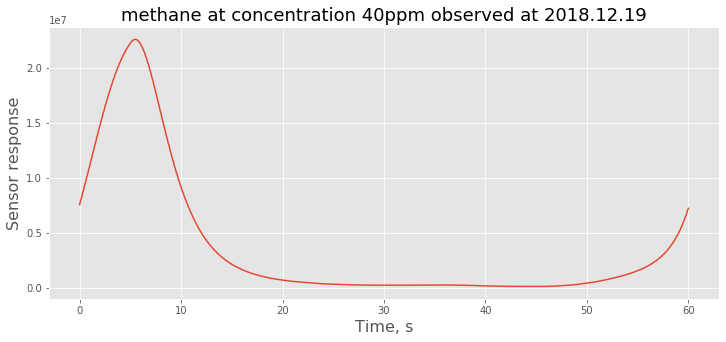

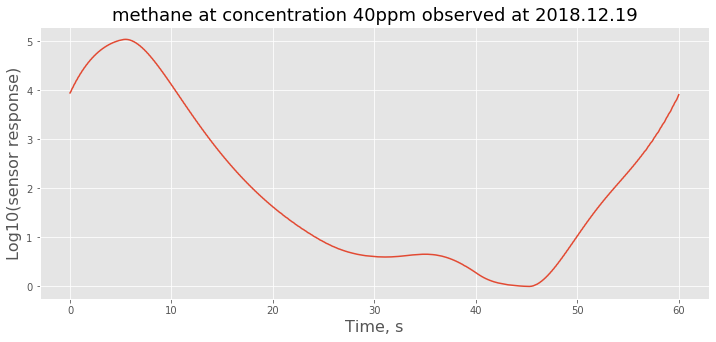

In [9]:
# let's make a plots of raw data sample
plt.rcParams['figure.figsize'] = (12,5)
row_number = np.random.randint(X_train_df.shape[0])
plt.plot(np.linspace(0,60, X_train_df.shape[1]), X_train_df.iloc[row_number])
plt.title("{gas} at concentration {concentration}ppm observed at {experiment}".format(\
                  gas=train_log.loc[row_number]['gas'],\
                  concentration=int(train_log.loc[row_number]['concentration']),\
                  experiment= train_log.loc[row_number]['experiment']).split('_')[0],\
                  fontsize = 18)
plt.ylabel('Sensor response', fontsize = 16), plt.xlabel('Time, s', fontsize = 16)
plt.show()

# and plot sample after default preprocessing
plt.rcParams['figure.figsize'] = (12,5)
plt.plot(np.linspace(0,60, X_train_lg10.shape[1]), X_train_lg10[row_number])
plt.title("{gas} at concentration {concentration}ppm observed at {experiment}".format(\
                  gas=train_log.loc[row_number]['gas'],\
                  concentration=int(train_log.loc[row_number]['concentration']),\
                  experiment= train_log.iloc[row_number]['experiment']).split('_')[0],\
                  fontsize = 18)
plt.ylabel('Log10(sensor response)', fontsize = 16), plt.xlabel('Time, s', fontsize = 16)
plt.show()

# 2. Polynomial approximation

To estimate the required polynom order, we will use the AIC-index calculated on the training data array. Note that since a neural network with a fully connected layer is used in solving the final problem, 

The number of model parameters = (polynomial order) * (number of hidden layer neurons). 

The error is calculated as sum of squared errors between original and approximated sensor signals. The best model is one for which there was a minimum value of the AIC index.

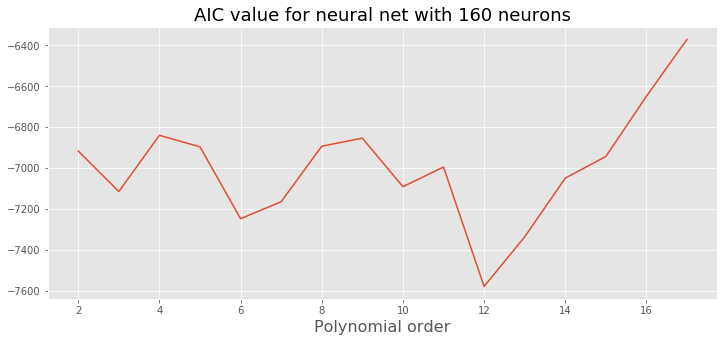

In [10]:
'''AICc = n * log(SSE/n) + (n + p) / (1 - (p + 2) / n)
SSE = Sum of Squared Errors for the training set
n = Number of training cases
p = Number of parameters (weights and biases)'''
NUM_HIDDEN = 160

results_list = []
for poly_coef in range(2, 18):
    
    
    X_train_mult = np.array(list(map(lambda x: get_poly_coeffs(x/np.sum(x), poly_coef), X_train_lg10)))

    X_train_coefs = np.array([list(i[0]) for i in X_train_mult])
    X_resid = np.array([list(i[1]) for i in X_train_mult])

    SSE = np.mean(X_resid)
    n = X_train.shape[1]
    p = np.copy(poly_coef)*NUM_HIDDEN

    results_list.append([p,  n *(np.log(2*np.pi*SSE/n)+1) + 2*p])
    
plt.plot(np.arange(2,18), np.array(results_list)[:,1])
plt.title('AIC value for neural net with {neurons} neurons'.format(neurons=NUM_HIDDEN), fontsize=18)
plt.xlabel('Polynomial order', fontsize=16)
plt.show()

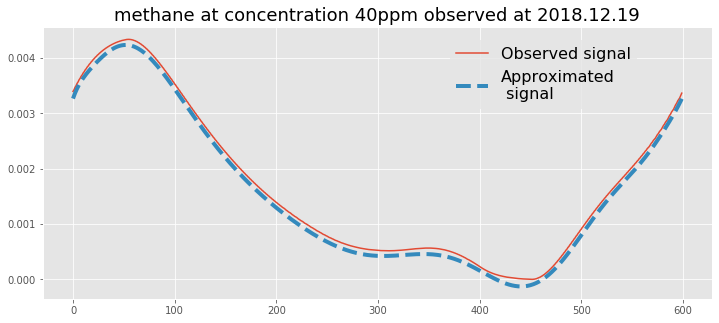

In [11]:
p = np.poly1d(X_train_coefs[row_number])
t = np.arange(0, X_train.shape[1])

plt.plot(X_train_lg10[row_number]/sum(X_train_lg10[row_number]))
plt.plot(t, p(t)-0.0001,'--',  linewidth = 4)
plt.title("{gas} at concentration {concentration}ppm observed at {experiment}".format(\
                  gas=train_log.loc[row_number]['gas'],\
                  concentration=int(train_log.loc[row_number]['concentration']),\
                  experiment= train_log.loc[row_number]['experiment']).split('_')[0],\
                  fontsize = 18)
leg = plt.legend(['Observed signal', 'Approximated\n signal'], prop={'size': 16}, loc='upper right', bbox_to_anchor=(0.9,0.98))
leg.get_frame().set_linewidth(0.0)
plt.show()

# 3. PCA decomposition

Demonstration of the application of the Principal Component Analysis approach. The loading matrix was calculated based on a training dataset. The determination of the number of principal components was carried out by their calculation of the explained variance. A figure of the cumulative value of the relative explained variance is presented below.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler_x = StandardScaler()
pca_model = PCA(n_components=100)

X_train_lg10_sc = scaler_x.fit_transform(X_train_lg10/np.sum(X_train_lg10, axis=1).reshape([-1,1]))
pca_model.fit(X_train_lg10_sc)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

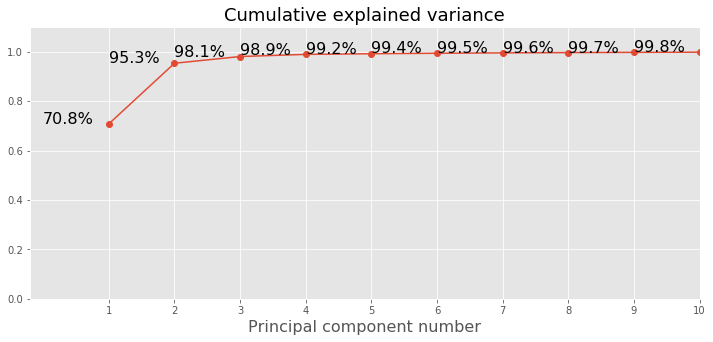

In [14]:
expl_var_cumulative = np.cumsum(pca_model.explained_variance_ratio_)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1,101), expl_var_cumulative, marker='o')

ax.set_ylim(0,1.1)
ax.set_xlim(-0.2,10)
ax.set_xticks(np.arange(1,11), minor=False)

for i,j in zip(range(10),expl_var_cumulative):
    ax.annotate("{:.1f}%".format(j*100),xy=(i,j), fontsize=16)

plt.xlabel("Principal component number", fontsize=16)
plt.title('Cumulative explained variance', fontsize=18)
plt.show()

# 4. Discrete Wavelet Transform

Here approximation wavelet coefficients of various levels were used. The [Daubechies 4](http://wavelets.pybytes.com/wavelet/db4/) mother wavelet was used. Thus, the number of features of each sample was reduced and low-pass filtering was performed. The approximate coefficients of levels 2-7 are shown below. As expected, the number of signs decreases from level to level by x2 times

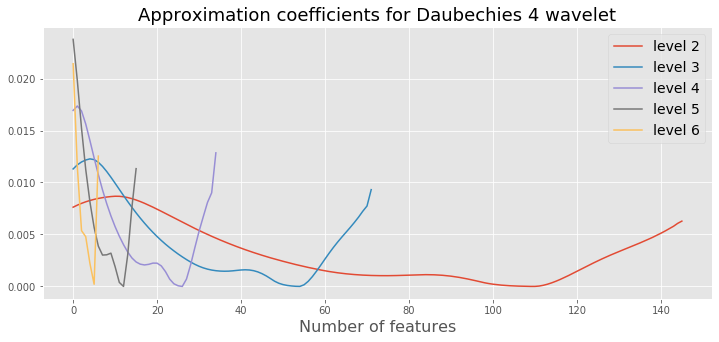

In [15]:
from pywt import wavedec
for lvl in range(2,7):
    dwt_sample = wavedec(X_train_lg10[row_number]/np.sum(X_train_lg10[row_number]), wavelet = 'db4', mode = 'zero', level=lvl)[0][7:-2]
    plt.plot(dwt_sample)
plt.legend(['level {}'.format(i) for i in range(2,7)], fontsize=14)
plt.xlabel("Number of features", fontsize=16)
plt.title("Approximation coefficients for Daubechies 4 wavelet", fontsize=18)
plt.show()